In [301]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

Описание датасета с Kaggle: "This dataset provides monthly totals of a US airline passengers from 1949 to 1960".

In [191]:
flight_data = pd.read_csv('/home/baishev/fl.csv')
flight_data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [192]:
flight_data.shape

(144, 2)

In [307]:
# определяем размеры графика

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

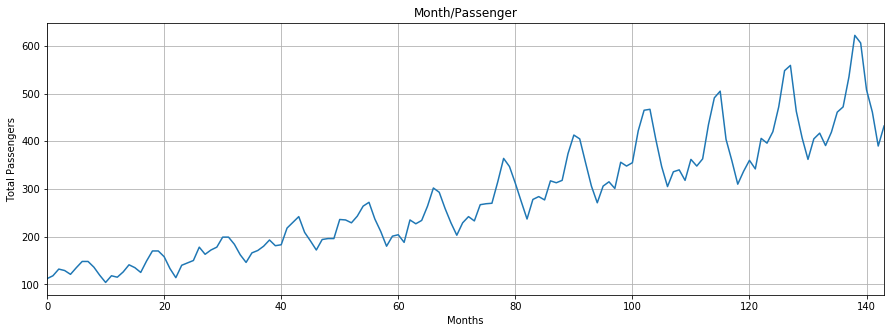

In [194]:
# строим график по данным из датасета

plt.title('Month/Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['#Passengers'])

In [195]:
flight_data.columns

Index(['Month', '#Passengers'], dtype='object')

In [196]:
# меняем тип данных на числовой

all_data = flight_data['#Passengers'].values.astype(float)

In [197]:
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


In [198]:
flight_data.rename(columns={"#Passengers": "Passengers"}, inplace=True)

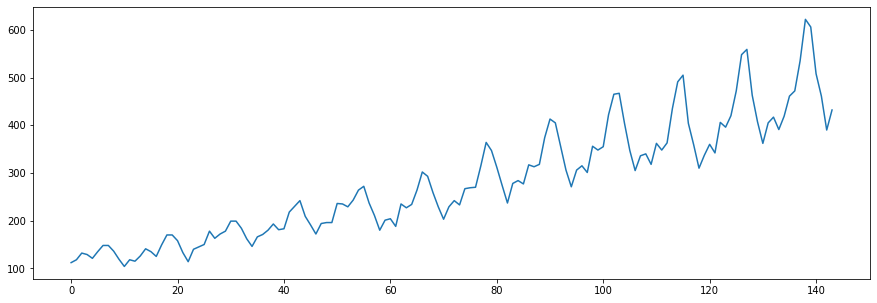

In [199]:
flight_data.Passengers.plot();

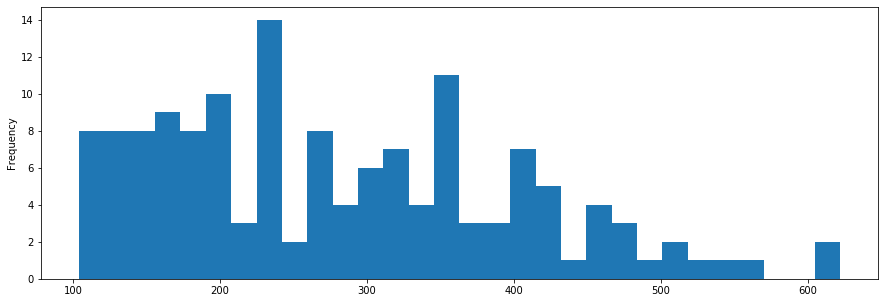

In [200]:
flight_data.Passengers.plot(kind = "hist", bins = 30);

In [201]:
# логарифмическое преобразование 

flight_data['PassengersModLog'] = np.log(flight_data.Passengers)

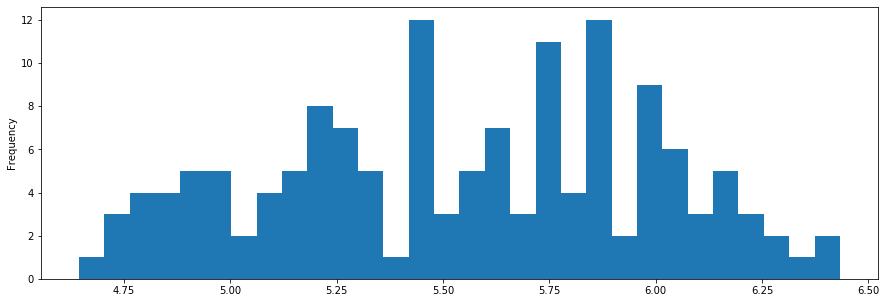

In [202]:
flight_data.PassengersModLog.plot(kind = "hist", bins = 30);

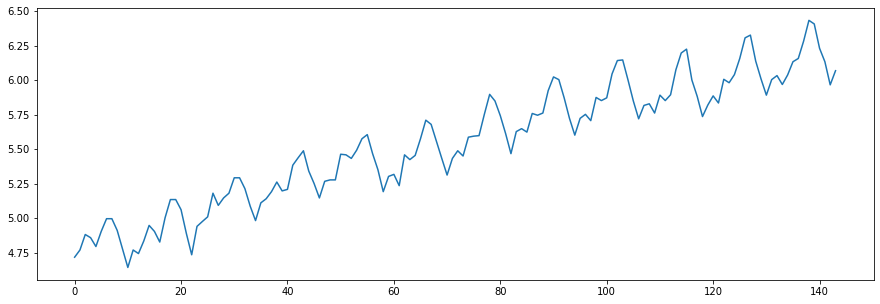

In [203]:
flight_data.PassengersModLog.plot();

<h1> Прогнозирование средним

In [204]:
model_mean_pred = flight_data.PassengersModLog.mean()

In [205]:
flight_data["PassengersMean"] = np.exp(model_mean_pred)

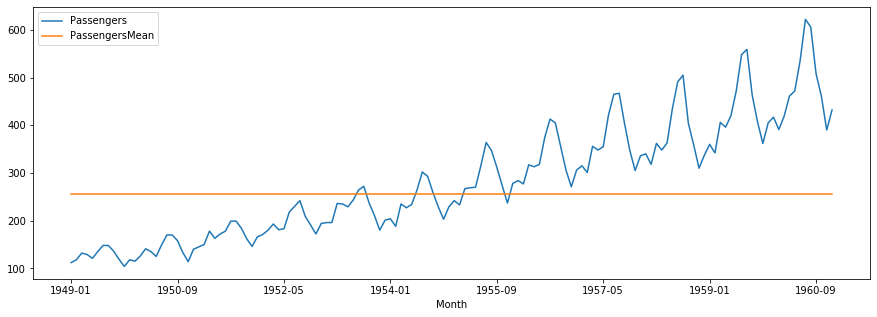

In [206]:
flight_data.plot(kind="line", x="Month", y = ["Passengers", "PassengersMean"]);

In [207]:
def RMSE(predicted, actual):
    se = (predicted - actual)**2
    mse = se.sum() / se.count()
    rmse = np.sqrt(mse)
    return rmse

In [208]:
model_mean_RMSE = RMSE(flight_data.PassengersMean, flight_data.Passengers)
model_mean_RMSE

122.1485556300248

In [209]:
flight_dataResults = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])
flight_dataResults.head()

,Model,Forecast,RMSE


In [210]:
flight_dataResults.loc[0,"Model"] = "Mean"
flight_dataResults.loc[0,"Forecast"] = np.exp(model_mean_pred)
flight_dataResults.loc[0,"RMSE"] = model_mean_RMSE
flight_dataResults.head()

,Model,Forecast,RMSE
0,Mean,255.233,122.149


<h1> Линейная модель

In [211]:
flight_data.head()

,Month,Passengers,PassengersModLog,PassengersMean
0,1949-01,112,4.718499,255.232772
1,1949-02,118,4.770685,255.232772
2,1949-03,132,4.882802,255.232772
3,1949-04,129,4.859812,255.232772
4,1949-05,121,4.795791,255.232772


In [212]:
flight_data.dtypes

Month                object
Passengers            int64
PassengersModLog    float64
PassengersMean      float64
dtype: object

In [214]:
flight_data.Month.min()

Timestamp('1949-01-01 00:00:00')

In [215]:
flight_data["timeIndex"] = flight_data.Month - flight_data.Month.min()

In [216]:
flight_data.head()

,Month,Passengers,PassengersModLog,PassengersMean,timeIndex
0,1949-01-01,112,4.718499,255.232772,0 days
1,1949-02-01,118,4.770685,255.232772,31 days
2,1949-03-01,132,4.882802,255.232772,59 days
3,1949-04-01,129,4.859812,255.232772,90 days
4,1949-05-01,121,4.795791,255.232772,120 days


In [217]:
flight_data["timeIndex"] =  flight_data["timeIndex"] / np.timedelta64(1, 'M')

In [218]:
flight_data.head()

,Month,Passengers,PassengersModLog,PassengersMean,timeIndex
0,1949-01-01,112,4.718499,255.232772,0.000000
1,1949-02-01,118,4.770685,255.232772,1.018501
2,1949-03-01,132,4.882802,255.232772,1.938438
3,1949-04-01,129,4.859812,255.232772,2.956940
4,1949-05-01,121,4.795791,255.232772,3.942586


In [219]:
flight_data["timeIndex"] = flight_data["timeIndex"].round(0).astype(int)

In [220]:
flight_data.timeIndex.tail()

139    139
140    140
141    141
142    142
143    143
Name: timeIndex, dtype: int64

In [221]:
flight_data.head()

,Month,Passengers,PassengersModLog,PassengersMean,timeIndex
0,1949-01-01,112,4.718499,255.232772,0
1,1949-02-01,118,4.770685,255.232772,1
2,1949-03-01,132,4.882802,255.232772,2
3,1949-04-01,129,4.859812,255.232772,3
4,1949-05-01,121,4.795791,255.232772,4


In [222]:
model_linear = smf.ols('PassengersModLog ~ timeIndex', data = flight_data).fit()

In [223]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PassengersModLog   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     1300.
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           2.41e-73
Time:                        01:19:54   Log-Likelihood:                 80.794
No. Observations:                 144   AIC:                            -157.6
Df Residuals:                     142   BIC:                            -151.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8237      0.023    209.248      0.000       4.778       4.869
timeIndex      0.0100      0.000     36.050      0.000       0.009       0.011
==============================================================================
Omnibus:                        3.750   Durbin-Watson:                   0.587
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                2.722
Skew:                           0.184   Prob(JB):                        0.256
Kurtosis:                       2.436   Cond. No.                         165.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [224]:
model_linear.params

Intercept    4.823717
timeIndex    0.010048
dtype: float64

In [225]:
c = model_linear.params[0]
c

4.823716664000667

In [226]:
m = model_linear.params[1]
m

0.01004838174169513

In [227]:
model_linear_pred = model_linear.predict()

In [228]:
model_linear_pred

array([4.82371666, 4.83376505, 4.84381343, 4.85386181, 4.86391019,
       4.87395857, 4.88400695, 4.89405534, 4.90410372, 4.9141521 ,
       4.92420048, 4.93424886, 4.94429724, 4.95434563, 4.96439401,
       4.97444239, 4.98449077, 4.99453915, 5.00458754, 5.01463592,
       5.0246843 , 5.03473268, 5.04478106, 5.05482944, 5.06487783,
       5.07492621, 5.08497459, 5.09502297, 5.10507135, 5.11511973,
       5.12516812, 5.1352165 , 5.14526488, 5.15531326, 5.16536164,
       5.17541002, 5.18545841, 5.19550679, 5.20555517, 5.21560355,
       5.22565193, 5.23570032, 5.2457487 , 5.25579708, 5.26584546,
       5.27589384, 5.28594222, 5.29599061, 5.30603899, 5.31608737,
       5.32613575, 5.33618413, 5.34623251, 5.3562809 , 5.36632928,
       5.37637766, 5.38642604, 5.39647442, 5.40652281, 5.41657119,
       5.42661957, 5.43666795, 5.44671633, 5.45676471, 5.4668131 ,
       5.47686148, 5.48690986, 5.49695824, 5.50700662, 5.517055  ,
       5.52710339, 5.53715177, 5.54720015, 5.55724853, 5.56729

In [229]:
flight_data["PassengersLinear"] = np.exp(model_linear_pred)

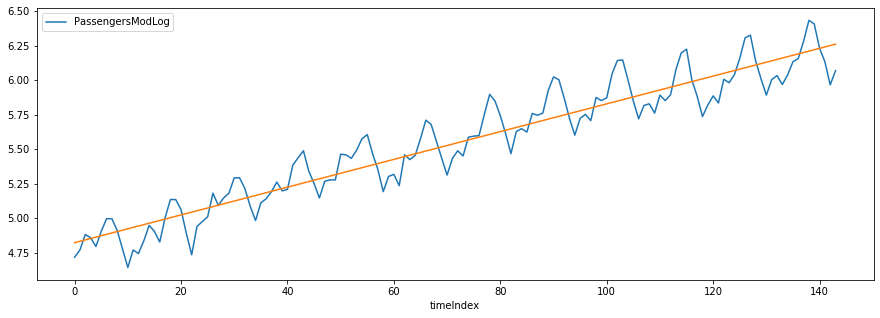

In [230]:
flight_data.plot(kind="line", x="timeIndex", y = "PassengersModLog")
plt.plot(flight_data.timeIndex,model_linear_pred, '-');

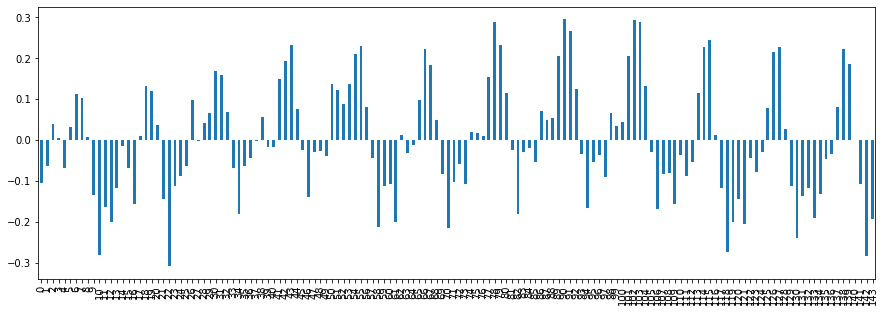

In [231]:
model_linear.resid.plot(kind = "bar")

In [232]:
model_linear_RMSE = RMSE(flight_data.PassengersLinear, flight_data.Passengers)
model_linear_RMSE

45.759814815442425

In [233]:
flight_dataResults.loc[1,"Model"] = "Linear"
flight_dataResults.loc[1,"Forecast"] = 'Linear'
flight_dataResults.loc[1,"RMSE"] = model_linear_RMSE
flight_dataResults.head()

,Model,Forecast,RMSE
0,Mean,255.233,122.149
1,Linear,Linear,45.7598


<h1>  Выделение тренда и сезонности


In [234]:
flight_data["PassengersModLogShift1"] = flight_data.PassengersModLog.shift()

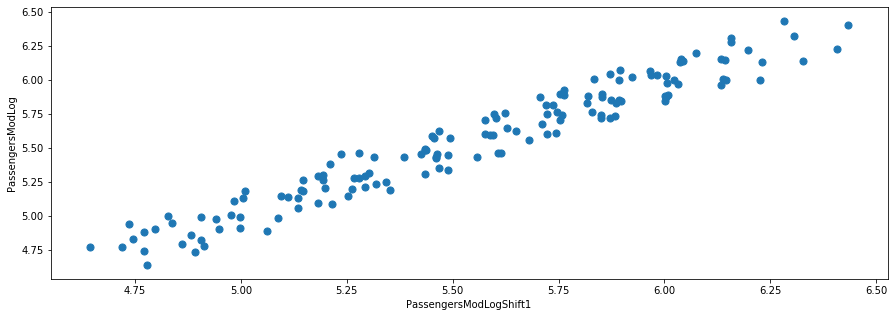

In [236]:
flight_data.plot(kind= "scatter", y = "PassengersModLog", x = "PassengersModLogShift1", s = 50)

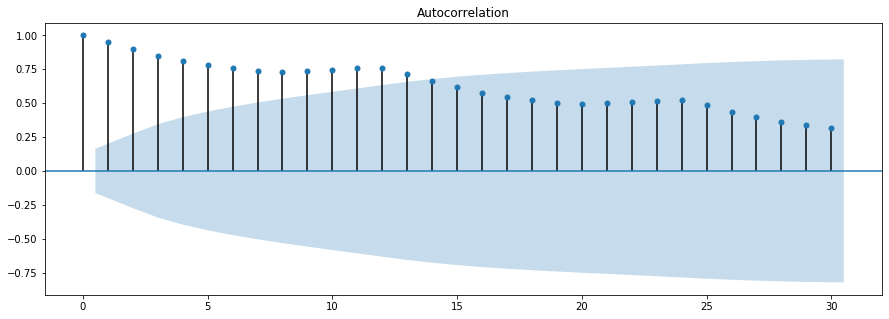

In [237]:
sm.graphics.tsa.plot_acf(flight_data['PassengersModLog'].values.squeeze(), lags=30)
plt.show()

In [238]:
flight_data["PassengersModLogDiff"] = flight_data.PassengersModLog - flight_data.PassengersModLogShift1

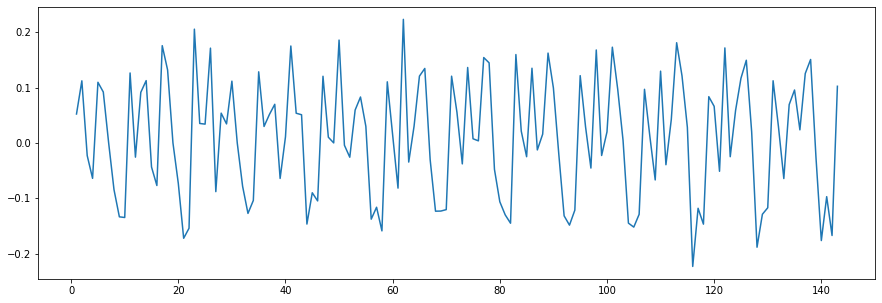

In [239]:
flight_data.PassengersModLogDiff.plot();

In [280]:
decomposition = seasonal_decompose(flight_data.PassengersModLog, model="additive")

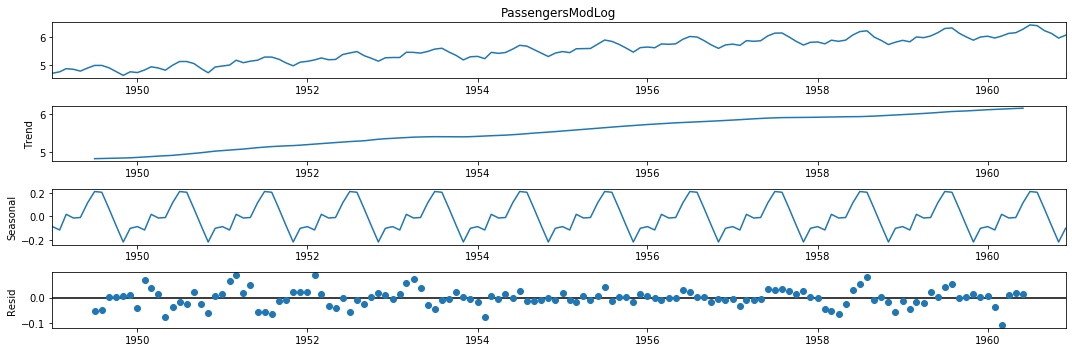

In [281]:
decomposition.plot();

In [282]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [283]:
flight_data["PassengersDecomp"] = np.exp(trend + seasonal)

In [284]:
model_Decomp_RMSE = RMSE(flight_data.PassengersDecomp, flight_data.Passengers)
model_Decomp_RMSE

9.985503176839769

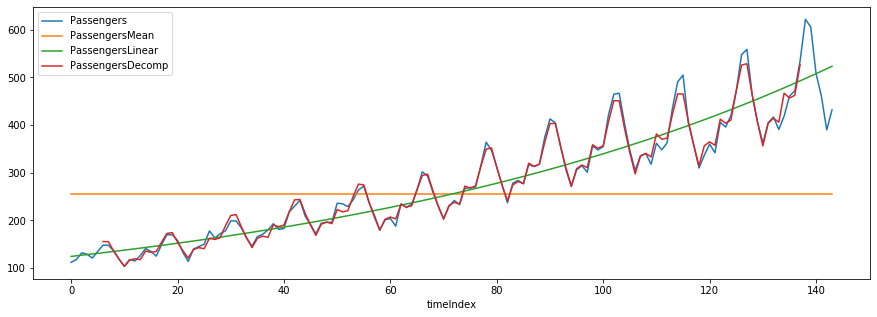

In [286]:
flight_data.plot(kind="line", x="timeIndex", y = ["Passengers", "PassengersMean", "PassengersLinear", "PassengersDecomp"])

In [287]:
flight_dataResults.loc[3,"Model"] = "PassengersDecomp"
flight_dataResults.loc[3,"Forecast"] = 'PassengersDecomp'
flight_dataResults.loc[3,"RMSE"] = model_Decomp_RMSE
flight_dataResults.head()

,Model,Forecast,RMSE
0,Mean,255.233,122.149
1,Linear,Linear,45.7598
3,PassengersDecomp,PassengersDecomp,9.9855


<h1> Стационарность ряда

In [288]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(flight_data.Passengers)[1])

Критерий Дики-Фуллера: p=0.991880


<h1> ARIMA

In [289]:
ts = flight_data.Passengers
ts_diff = flight_data.PassengersModLogDiff
ts_diff.dropna(inplace = True)

In [291]:
lag_acf = acf(ts_diff, nlags=20)

In [292]:
lag_acf

array([ 1.        ,  0.19975134, -0.12010433, -0.15077204, -0.32207432,
       -0.08397453,  0.02577843, -0.11096075, -0.33672146, -0.11558631,
       -0.10926704,  0.20585223,  0.84142998,  0.21508704, -0.13955394,
       -0.11599576, -0.27894284, -0.05170646,  0.01245814, -0.1143576 ,
       -0.33717439])

In [293]:
ACF = pd.Series(lag_acf)

In [294]:
ACF

0     1.000000
1     0.199751
2    -0.120104
3    -0.150772
4    -0.322074
5    -0.083975
6     0.025778
7    -0.110961
8    -0.336721
9    -0.115586
10   -0.109267
11    0.205852
12    0.841430
13    0.215087
14   -0.139554
15   -0.115996
16   -0.278943
17   -0.051706
18    0.012458
19   -0.114358
20   -0.337174
dtype: float64

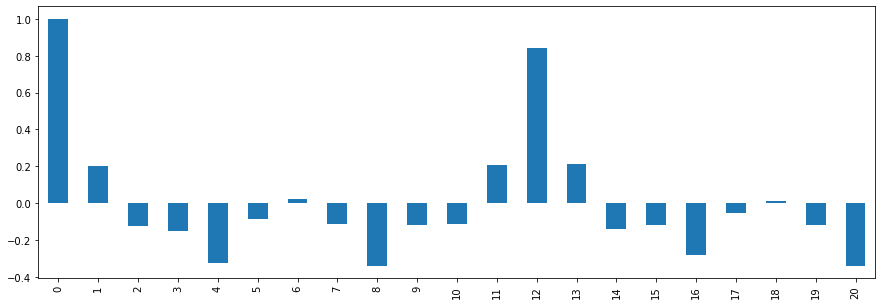

In [312]:
ACF.plot(kind = "bar");

In [296]:
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

In [297]:
PACF = pd.Series(lag_pacf)

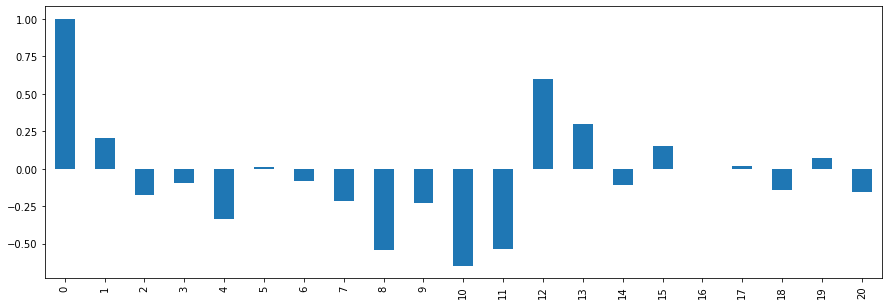

In [311]:
PACF.plot(kind = "bar");

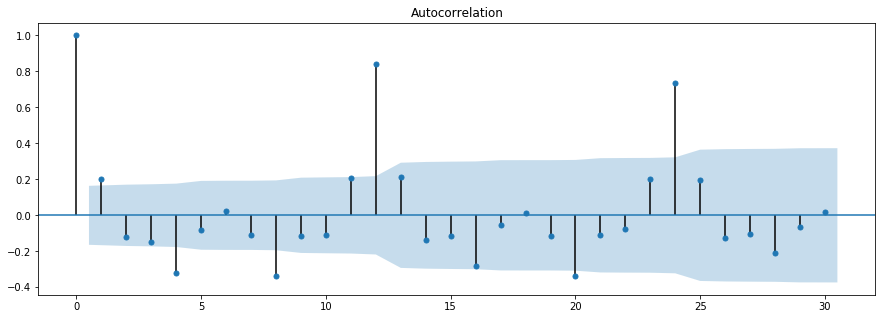

In [310]:
sm.graphics.tsa.plot_acf(ts_diff, lags=30)
plt.show()

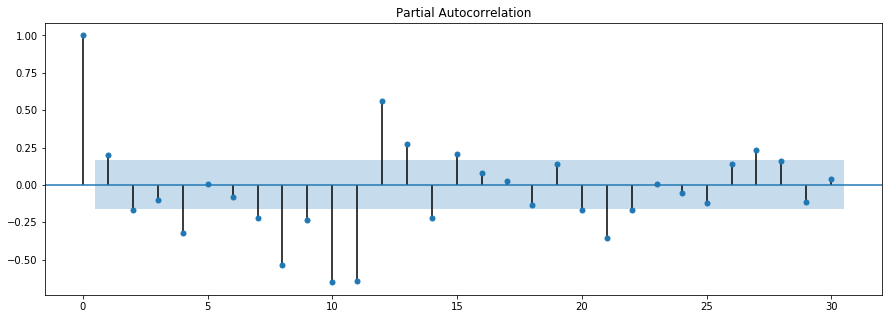

In [309]:
sm.graphics.tsa.plot_pacf(ts_diff, lags=30)
plt.show()

<h1> Построение ARIMA

In [302]:
ts_diff.head()

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
Name: PassengersModLogDiff, dtype: float64

In [303]:
model_AR1MA = ARIMA(ts_diff, order=(1,0,1))

In [304]:
results_ARIMA = model_AR1MA.fit(disp = -1)

In [305]:
results_ARIMA.fittedvalues.head()

Month
1949-02-01    0.009800
1949-03-01    0.017618
1949-04-01    0.025229
1949-05-01   -0.010225
1949-06-01    0.008528
dtype: float64

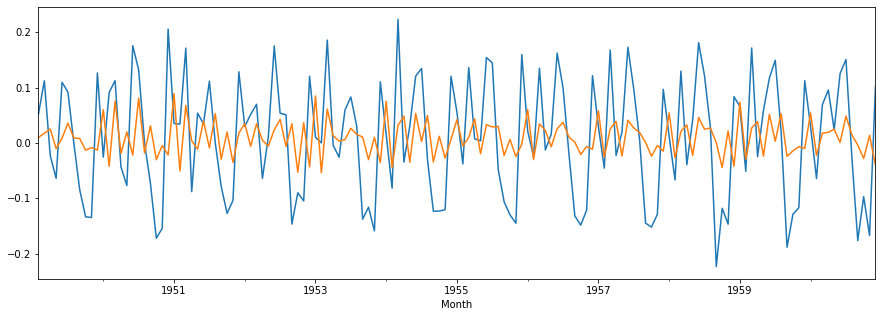

In [308]:
ts_diff.plot()
results_ARIMA.fittedvalues.plot();

In [313]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.tail()

Month
1960-08-01    0.014654
1960-09-01   -0.003923
1960-10-01   -0.028363
1960-11-01    0.013642
1960-12-01   -0.040849
dtype: float64

In [314]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.tail()

Month
1960-08-01    1.413108
1960-09-01    1.409185
1960-10-01    1.380822
1960-11-01    1.394465
1960-12-01    1.353615
dtype: float64

In [315]:
print(ts.iloc[0])

112


In [334]:
predictions_ARIMA_log = pd.Series(ts.iloc[0], index=ts.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.tail()

Month
1960-08-01    113.413108
1960-09-01    113.409185
1960-10-01    113.380822
1960-11-01    113.394465
1960-12-01    113.353615
dtype: float64

In [327]:
flight_data['PassengersARIMA'] = np.exp(predictions_ARIMA_log)

In [333]:
flight_data['PassengersARIMA']

Month
1949-01-01    4.375039e+48
1949-02-01    4.418126e+48
1949-03-01    4.496655e+48
1949-04-01    4.611546e+48
1949-05-01    4.564631e+48
                  ...     
1960-08-01    1.797576e+49
1960-09-01    1.790537e+49
1960-10-01    1.740466e+49
1960-11-01    1.764372e+49
1960-12-01    1.693751e+49
Name: PassengersARIMA, Length: 144, dtype: float64

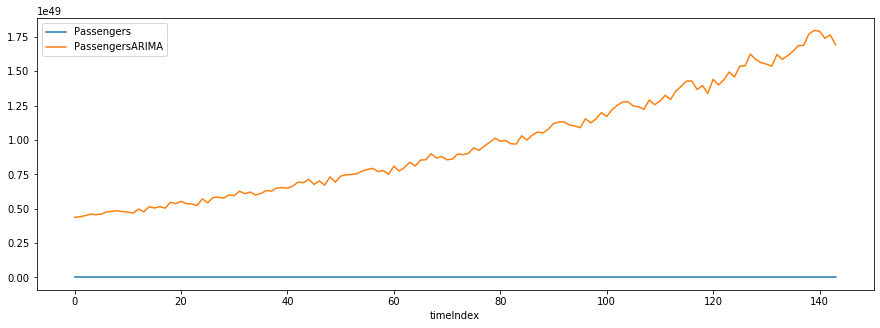

In [336]:
flight_data.plot(kind="line", x="timeIndex", y = ["Passengers", "PassengersARIMA"]);

<h1> LSTM-модель

In [11]:
# делим данные на обучающие и тестовые

test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [12]:
print(len(train_data))
print(len(test_data))

132
12


In [13]:
# нормализуем данные

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [14]:
# от -1 до 1

print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


In [15]:
# данные в торчевой тензор

train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [16]:
# функция возвращает лист, содержащий входные последовательности заданной длины и входные последовательности заданной длины + 1 значение (т.е. верное значение, которое будет прогнозироваться)

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [17]:
# длина последовательности 12, т.к. работаем с месяцами 

train_window = 12

In [18]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [19]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

In [20]:


class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [21]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
model

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [47]:
epochs = 126

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00013839
epoch:  26 loss: 0.00000277
epoch:  51 loss: 0.00007012
epoch:  76 loss: 0.00008094
epoch: 101 loss: 0.00000301
epoch: 125 loss: 0.0000000480


In [48]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [49]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())


In [50]:
test_inputs[fut_pred:]

[0.3508840799331665,
 0.26202306151390076,
 0.5525336861610413,
 0.4964837431907654,
 0.5561328530311584,
 0.6321958899497986,
 0.7713857293128967,
 0.9298661351203918,
 1.006992220878601,
 0.8899192810058594,
 0.648288369178772,
 0.3900338411331177]

In [51]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[411.32612818]
 [391.11024649]
 [457.2014136 ]
 [444.45005158]
 [458.02022406]
 [475.32456496]
 [506.99025342]
 [543.04454574]
 [560.59073025]
 [533.95663643]
 [478.98560399]
 [420.23269886]]


In [337]:
test_data

array([417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

In [338]:
RMSE_loss = np.sqrt(np.mean((actual_predictions-test_data)**2))

In [52]:
x = np.arange(132, 144, 1)
print(x)


[132 133 134 135 136 137 138 139 140 141 142 143]


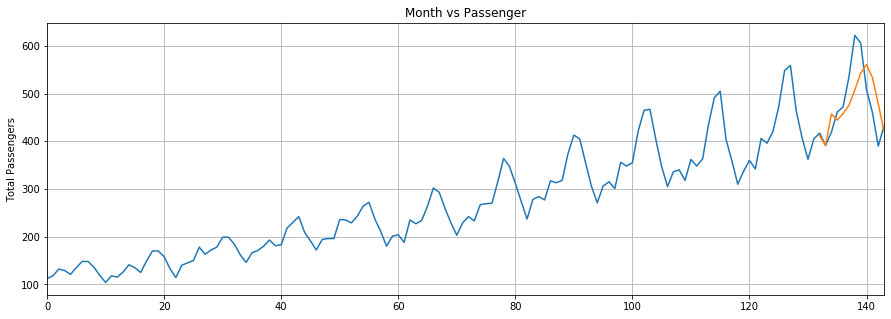

In [53]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['#Passengers'])
plt.plot(x,actual_predictions)
plt.show()


In [339]:
print(f'RMSE: {RMSE_loss}')

RMSE: 90.66172759673931
